# Lab 2

Modelling and computation in hazard assessment
26-27 Februrary 2024

In Lab 1, we introduced fundamental data analysis and modelling concepts. In Lab 2 we will demonstrate more advanced modelling techniques that are likely to be seen in practice. Once more, the practical demonstration follows the concepts introduced in the lectures.

- In the first section, we will introduce the concept of k-fold cross-validation.

- Then we'll load the same dataset with in vitro genotoxocity data used in Lab 1 and use cross-validation for estimating the model generalisation error.

- In the next step, we will plot the learning curve to investigate the predictive performance gap between the training and validation sets

- Then we will plot the validation curve to investigate how the predictive performance depends on the model parameters

- Finally, we will attempt to develop models for all Ames strains with and without metabolic activation and compare their predictive performances.

Note: This training is using a public computing platform and hence all data are not proprietary, not confidential and not subject to IPR restrictions. Still, the dataset has not been openly shared as this would require the inclusion of the relevant terms and conditions of the applicable licences. Be aware with using confidential data in public computing platforms and do not share this dataset further.

##Setup

Before we continue with Lab2 we need to install the neccesary packages and import them. We mostly repeat the cells we have seen in Lab 1, so we will not delve into the details.

### Installations and imports

In [1]:
# @title
%%capture

# install the necessary packages that are not preinstalled in google colab
!pip install rdkit
!pip install tqdm

In [3]:
# @title
%%capture

# import libraries (locally needed depedendencies will be imported when needed)
import numpy as np
import pandas as pd
import requests
from pathlib import Path
import time
from tqdm.notebook import tqdm
from rdkit import Chem                        #cheminformatics
from rdkit.Chem import AllChem                #cheminformatics
from rdkit.Chem import Draw                   #cheminformatics
from rdkit.Chem.Draw import rdMolDraw2D       #cheminformatics
from rdkit.Chem.Draw import IPythonConsole    #cheminformatics
import torch                                  #modelling
import torch.nn.functional as F               #modelling
from torch.utils.data import TensorDataset    #modelling
from torch.utils.data import DataLoader       #modelling
from sklearn.model_selection import train_test_split  #modelling
from sklearn.metrics import roc_auc_score             #modelling
from sklearn.metrics import balanced_accuracy_score   #modelling
from sklearn.metrics import recall_score              #modelling
import matplotlib.pyplot as plt               #visualisation
import seaborn as sns                         #visualisation
%matplotlib inline

# enable progress bar for the pandas.apply
tqdm.pandas()

# setup pandas
pd.set_option('expand_frame_repr', False)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision",3)
pd.set_option("max_colwidth", 250)
pd.options.mode.copy_on_write = True

In [4]:
# setup the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# mount the google drive in case we wish to persist results, this cell is not necessary for the remaining of the Lab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the dataset and compute descriptors

We can now load the PyTorch dataset we created in Lab 1 and continue with Lab 2.

In [6]:
# fetch the dataset from the github repository
import requests
from getpass import getpass

# Provide your GitHub credentials (will be removed when the repository becomes public)
token = getpass("Enter your GitHub token: ")

# Set up the file URL
file_url = "https://raw.githubusercontent.com/pkaramertzanis/modelling_hazard_assessment/master/datasets/genotoxicity_dataset.xlsx"  # Updated URL

# Use the token for authentication
headers = {'Authorization': f'token {token}'}
response = requests.get(file_url, headers=headers)

# Save the file locally
if response.status_code == 200:
    with open(Path(file_url).name, "wb") as file:
        file.write(response.content)
    print("File downloaded successfully!")
else:
    print(f"Failed to download file: {response.status_code}")

Enter your GitHub token: ··········
File downloaded successfully!


In [7]:
# load the dataset into a pandas dataframe
gentox_data = pd.read_excel('genotoxicity_dataset.xlsx')
# exclude ambiguous genotoxicity calls
msk = gentox_data['genotoxicity'] != 'ambiguous'
gentox_data = gentox_data[msk]
# pivot the endpoint data
gentox_data['genotoxicity'] = gentox_data['genotoxicity'].map({'positive': 1, 'negative': 0})
gentox_data = gentox_data.pivot(index='smiles_std', columns='endpoint', values='genotoxicity').reset_index(drop=False)
gentox_data.columns.name = None
gentox_data.head(n=5) # display the first 5 rows

,smiles_std,"Escherichia coli (WP2 Uvr A), no","Escherichia coli (WP2 Uvr A), yes","Salmonella typhimurium (TA 100), no","Salmonella typhimurium (TA 100), yes","Salmonella typhimurium (TA 1535), no","Salmonella typhimurium (TA 1535), yes","Salmonella typhimurium (TA 1537), no","Salmonella typhimurium (TA 1537), yes","Salmonella typhimurium (TA 98), no","Salmonella typhimurium (TA 98), yes"
0,BrC(Br)Br,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,BrC(Br)C(Br)Br,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BrC1CCCC1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4,BrC=Cc1ccccc1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The above data structure allows fitting models for any of the Ames strain and metabolic activation combinations.

In [8]:
# check for duplicate smiles
gentox_data['smiles_std'].duplicated().sum()

0

We can now proceed to the conversion of the smiles to RDKit molecules and the calculation of the fingerprints. We will be using binary fingerprints of length 1024 and radius 2 as in Lab 1.

In [9]:
# set up the fingerprint calculation
fingerprint_parameters = {'radius': 2,
                          'fpSize': 1024,
                          'type': 'count' # 'binary', 'count'
                          }
# create the fingerprint generator
fpgen = AllChem.GetMorganGenerator(radius=fingerprint_parameters['radius'], fpSize=fingerprint_parameters['fpSize'],
                                   countSimulation=False, includeChirality=False)

# convert smiles to RDKit molecules and compute the fingerprints
def compute_mol_fingerprint(smiles):
  mol = Chem.MolFromSmiles(smiles)
  fingerprint = fpgen.GetFingerprint(mol).ToList()
  return mol, fingerprint
gentox_data[['mol', 'fingerprint']] = gentox_data.progress_apply(lambda row: compute_mol_fingerprint(row['smiles_std']), result_type='expand', axis='columns')

  0%|          | 0/4236 [00:00<?, ?it/s]

### Model architecture and training/inference utility functions

We start by defining a simple feedforward neural network model. The model architecture is identical as in Lab 1.

In [11]:
from typing import Callable
class FFNNModel(torch.nn.Module):

    def __init__(self,
                 n_input: int,
                 hidden_layers: list[int],
                 dropout: float,
                 n_classes: [int],
                 activation_function: Callable = torch.nn.functional.leaky_relu):
        '''
        Implements a simple feedforward neural network in PyTorch.
        It can be used for both simple and multitask models.

        The model is initialised with the following parameters:
        :param n_input: number of input features (fingerprint length)
        :param hidden_layers: array with the number of neurons in each hidden layer
        :param dropout: dropout rate
        :param n_classes: number of output classes
        :param activation_function: PyTorch activation function, e.g. torch.nn.functional.relu or torch.nn.functional.leaky_relu
        '''
        super().__init__()


        # general parameters
        self.dropout = dropout
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.n_classes = n_classes

        # set up the linear layers
        self.linear_layers = torch.nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(n_input, self.hidden_layers[0]))
        for i in range(len(self.hidden_layers)-1):
            self.linear_layers.append(torch.nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))

        # set up the output layers, one for each task
        self.out_layers = torch.nn.ModuleList()
        for n_class in self.n_classes:
            self.out_layers.append(torch.nn.Linear(self.hidden_layers[-1], n_class))

        # dropout layer
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, task_id: int):

        # apply the linear layers, dropout after activation
        for module in self.linear_layers:
            x = self.activation_function(module(x))
            x = self.dropout(x)

        # apply the output layer (classification, produces logits)
        output = self.out_layers[task_id](x)
        return output

We now define a compact function for training. For convenience we pack into it all elements we need to build a model starting from only the fingerprints and the labels. We use the fraction of positives for scaling the loss function.

In [42]:
# train the model
def train_model(X, y, hidden_layes, dropout, num_epochs=20):
  '''
    param X: array with fingerprints
    param y: array with labels
    param hidden_layers: array with the number of neurons in each hidden layer
    param dropout: dropout rate
    param num_epochs: number of epochs to train the model

  Returns the loss history amd the trained model
  '''
  # set the seed for deterministic behaviour
  torch.manual_seed(1)

    # initiate the model
  net = FFNNModel(n_input=1024, hidden_layers=hidden_layers, dropout=dropout, n_classes=[2])
  net.to(device)

  # set up the optimiser
  optimiser = torch.optim.Adam(net.parameters(), lr=0.001,
                             betas=[0.9, 0.999], eps=1e-08,
                             weight_decay=1.e-6, amsgrad=False)

  # set the dataset
  X_tensor = torch.tensor(np.stack(X.values, axis=0), dtype=torch.float32).to(device)
  y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)
  dset = TensorDataset(X_tensor, y_tensor)

  # create the dataloader
  batch_size = 512
  dataloader = DataLoader(dset, batch_size=batch_size, shuffle=True, drop_last=True)

  # set up the loss function
  weights = torch.tensor([y.sum()/len(y), 1-y.sum()/len(y)], dtype=torch.float32)
  weights = weights/weights.norm()
  weights = weights.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

  # train the model
  net.train()
  loss_history = []
  print('start training')
  for epoch in tqdm(range(num_epochs)):
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
      optimiser.zero_grad()
      logits = net(X_batch, task_id=0)
      loss = loss_fn(logits, y_batch)
      loss_history.append({'epoch': epoch, 'batch': i_batch, 'loss': loss.item()})
      loss.backward()
      optimiser.step()
  loss_history = pd.DataFrame(loss_history)
  return net, loss_history

Let's check that the function works as expected

start training


  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

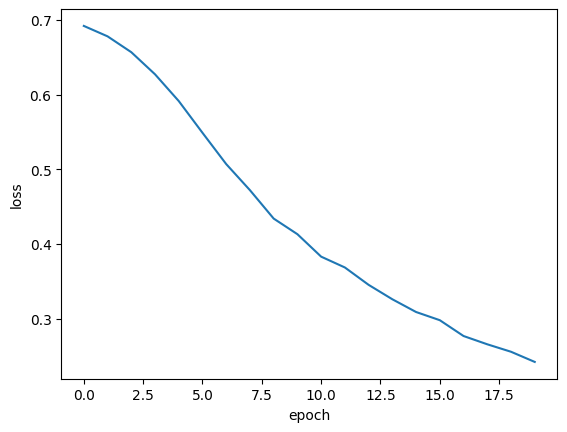

In [43]:
# check the function works as expected
endpoint = 'Salmonella typhimurium (TA 100), yes'
msk = gentox_data[endpoint].notnull()
X = gentox_data.loc[msk, 'fingerprint']
y = gentox_data.loc[msk, endpoint]

# set the model hyperparameters to some arbitrary values
hidden_layers = [32, 32]
dropout = 0.2

# train the model and plot the loss
net, loss_history = train_model(X, y, hidden_layers, dropout)
plt.plot(loss_history.groupby('epoch')['loss'].mean())
plt.xlabel('epoch')
plt.ylabel('loss')

We finally create a utility function to run predictions and compute the predicitve performance metrics.

In [44]:
# inference
def predict(X, y, net):
  '''
    param X: array with fingerprints
    param y: array with labels to compare predictions against
    param net: trained model

    Returns the predictions and a dictionary with the sensitivity, specificity and balanced accuracy
  '''
  #  generate the predictions
  net.eval()
  X_tensor = torch.tensor(np.stack(X.values, axis=0), dtype=torch.float32).to(device)
  y_pred_logits = net(X_tensor, task_id=0).detach().cpu()
  y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                            columns=['negative (probability)', 'positive (probability)'])
  y_pred = np.where(y_pred_prob['positive (probability)'] > 0.5, 1, 0)

  # predictive performance metrics
  y = y.astype(int)
  sensitivity  = recall_score(y, y_pred, pos_label=1)
  specificity  = recall_score(y, y_pred, pos_label=0)
  balanced_accuracy = balanced_accuracy_score(y, y_pred)

  return y_pred, {'sensitivity': sensitivity, 'specificity': specificity, 'balanced_accuracy': balanced_accuracy}

Let's check that the function works as expected

In [45]:
y_pred, metrics = predict(X, y, net)
metrics

{'sensitivity': 0.9409871244635193,
 'specificity': 0.9223257878384377,
 'balanced_accuracy': 0.9316564561509785}

The metrics are of course overly optimistic because we used the whole dataset for both training and model evaluation as the purpose was to check that our model can lean.

With these functions we are now ready for building some realistic models. Before we attempt to optimise the model hyperparameters, we will use cross-validation to estimate the predictive performace in a more reliable way.

## k-Fold cross validation for model evaluation

The name cross validation originates from the crossing over the training and validation stages in successive rounds. The idea is to avoid arbitrarily fixing the part of the dataset used for evaluation. Instead we wish to give each sample in the dataset the opportunity to be used in the validation set (and also for training). How can we do this?

In each round we split the dataset into k parts. k-1 of these parts are merged and used for training and the remaining part is used for validation. This process is repeated k times (image from https://doi.org/10.48550/arXiv.1811.12808). Each of the k trainings is using the same model hyperparameters, e.g. the same number of hidden layers and drop-out rate. After completing the k-folds we have obtained k values of the performance metric of interest, such as the balanced accuracy. The final estimate of the balanced accuracy for unseen data (a metric for the model generalisation) is taken as the arithmetic mean of the performance metric computed for the k evaluation sets.

k-fold cross validation is not the only method used for model evaluation. In practice, one may encounter simple normal approximations (we asssume that the prediction correctness is a Bernoulli trial) or repeated hold-out with bootstrapping using various corrections.

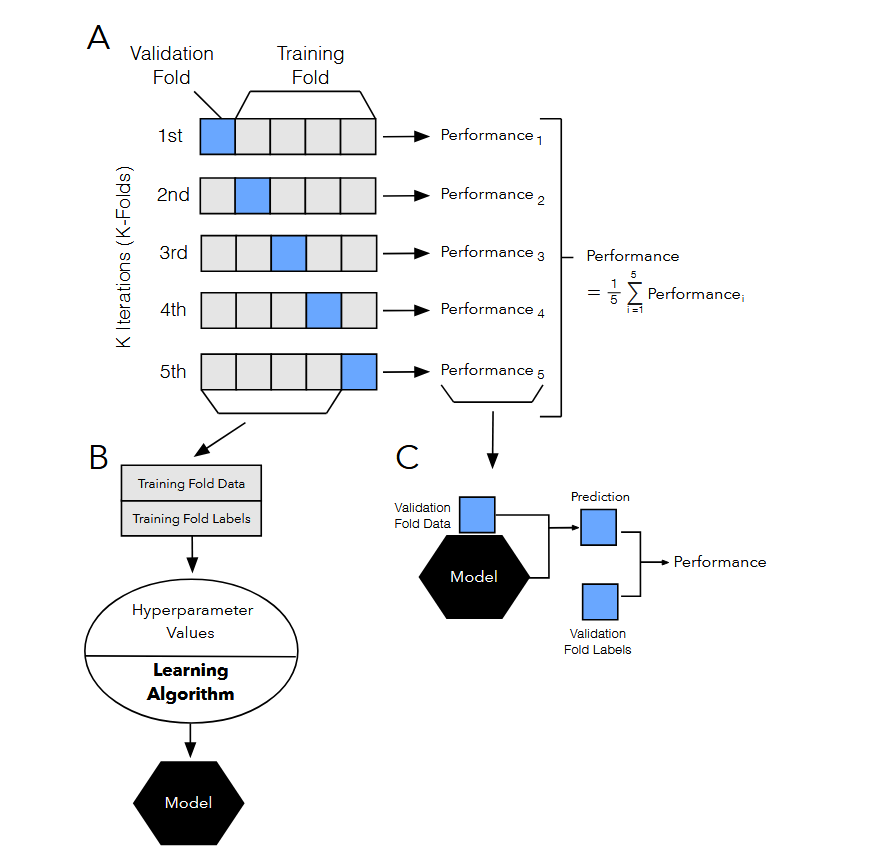

The remaining of this section uses k-fold cross validation for estimating the generalisation predictive performance of our neural network model using the same arbitrary model hyperparameters as in Lab 1. The next section moves a step further and attempts to increase the predictive performance by altering the model hyperparameters and selecting the optimal model within the allowed hyperparameter space.

Cross-validation is used for both of these tasks. It may not be the panacea to all machine learning challenges, but it remains the most commonly used technique for model evaluation and model selection.

In the next cell we will implement a stratified 10-fold cross validation function.


In [46]:
from sklearn.model_selection import StratifiedKFold

def cross_validation(X, y, hidden_layers, dropout, k=10, random_state=1):
  '''
    param X: array with fingerprints
    param y: array with labels
    param hidden_layers: array with the number of neurons in each hidden layer
    param dropout: dropout rate
    param k: number of folds
    param random_state: random seed

    Returns a dataframe with the cross validation metrics

  '''
  kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
  fold_metrics = []
  for fold, (train_index, test_index) in tqdm(enumerate(kfold.split(X, y))):
    print(f'Fold {fold}')
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # train the model using the training folds
    net, loss_history = train_model(X_train, y_train, hidden_layes=hidden_layers, dropout=dropout)
    # evaluate the model using the validation fold
    y_pred_val, metrics_val = predict(X.iloc[test_index], y.iloc[test_index], net)
    metrics = {k + ' (validation)': v for k, v in metrics_val.items()}
    fold_metrics.append(metrics)
    # evaluate the model using the training folds
    y_pred_train, metrics_train = predict(X.iloc[train_index], y.iloc[train_index], net)
    metrics.update({k + ' (training)': v for k, v in metrics_train.items()})
    fold_metrics.append(metrics)
  fold_metrics = pd.DataFrame(fold_metrics)
  return fold_metrics

Let's use the function for the same strain (TA100S9+) we have been using so far. This will take ~30 sec as we are training a model for each fold.

In [47]:
# set the dataset
endpoint = 'Salmonella typhimurium (TA 100), yes'
msk = gentox_data[endpoint].notnull()
X = gentox_data.loc[msk, 'fingerprint']
y = gentox_data.loc[msk, endpoint]

# set the model hyperparameters to some arbitrary values
hidden_layers = [32, 32]
dropout = 0.2

# cross validation
metrics = cross_validation(X, y, hidden_layers, dropout)

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 5
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 6
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 7
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 8
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 9
start training


  0%|          | 0/20 [00:00<?, ?it/s]

We can now analyse the collected metrics for the different folds.

,sensitivity (validation),specificity (validation),balanced_accuracy (validation),sensitivity (training),specificity (training),balanced_accuracy (training)
count,20.000,20.000,20.000,20.000,20.000,20.000
mean,0.706,0.827,0.766,0.933,0.901,0.917
std,0.048,0.025,0.021,0.006,0.009,0.003
min,0.613,0.800,0.733,0.926,0.888,0.911
25%,0.677,0.809,0.752,0.928,0.891,0.916
50%,0.704,0.818,0.768,0.931,0.904,0.917
75%,0.742,0.853,0.783,0.939,0.909,0.920
max,0.766,0.867,0.805,0.944,0.911,0.922


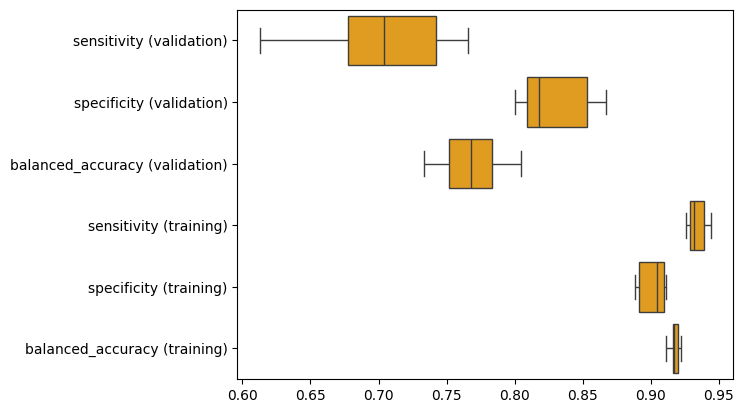

In [48]:
sns.boxplot(data=metrics, orient='h', color='orange')
metrics.describe()

What do you think about the predictive performance of the model?

How sensitive are these metrics? We can investigate this by changing the number of folds to 5 and use a different random number seed for splitting the data.

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

,sensitivity (validation),specificity (validation),balanced_accuracy (validation),sensitivity (training),specificity (training),balanced_accuracy (training)
count,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.713,0.811,0.762,0.919,0.885,0.902
std,0.035,0.022,0.019,0.009,0.007,0.005
min,0.677,0.783,0.737,0.909,0.876,0.893
25%,0.688,0.796,0.755,0.911,0.882,0.902
50%,0.701,0.811,0.757,0.917,0.884,0.904
75%,0.731,0.823,0.771,0.929,0.887,0.905
max,0.770,0.842,0.791,0.929,0.896,0.906


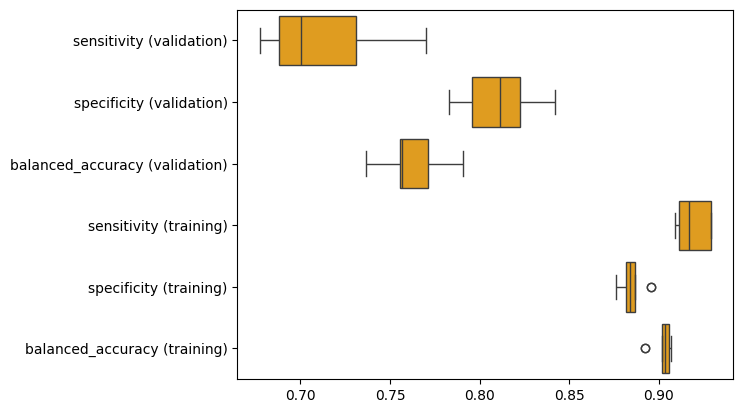

In [49]:
metrics = cross_validation(X, y, hidden_layers, dropout, k=5, random_state=2)
sns.boxplot(data=metrics, orient='h', color='orange')
metrics.describe()

The change in the matrics seems to be within one standard deviation.

We can see that the model metrics have some variability and need to be reported with their error margins. Keep this in mind when you read the literature or discuss the relative performance of models. Small differences in predicitve performance are not always real.

## Learning curves

An interesting question to ask is if the model could be improved further with additional data. Intuitively, we may think that a model can always improve with more data, but this is not true for a model that has already reached its limit (and hence is now of high bias).

Generating new data is often difficult or impossible. But insead of using more data we can use less and check how the predictive performance metrics evolve for the training and the validation sets.

Calculating the learning curve is more computationally expensive as we have to repeat the cross validation for every dataset slice we wish to try. Using a T4 GPU the calculation takes roughly 60 sec.

In [72]:
# set the model hyperparameters to some arbitrary values
hidden_layers = [256, 256]
dropout = 0.7

# specify which slice of the data to use for buidling and validating the model
slice_sizes = np.linspace(0.1, 1., 10)

# reshuffle the data
gentox_data_shuffled = gentox_data.sample(frac=1., random_state=1)
endpoint = 'Salmonella typhimurium (TA 100), yes'
msk = gentox_data_shuffled[endpoint].notnull()

learning_curve = []
for slice_size in tqdm(slice_sizes):
  X = gentox_data_shuffled.loc[msk, 'fingerprint'].iloc[:int(np.floor(slice_size*msk.sum()))]
  y = gentox_data_shuffled.loc[msk, endpoint].iloc[:int(np.floor(slice_size*msk.sum()))]

  # cross validation
  metrics = cross_validation(X, y, hidden_layers, dropout, k=5, random_state=1)
  metrics['number of datapoints'] = int(np.floor(slice_size*msk.sum()))
  learning_curve.append(metrics)
learning_curve = pd.concat(learning_curve, axis='index', sort=False, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Fold 0
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 2
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 3
start training


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 4
start training


  0%|          | 0/20 [00:00<?, ?it/s]

We can plot the metrics for the training set and the validation set as a function of the dataset size.

In [73]:
# learning_curve = pd.concat(learning_curve, axis='index', sort=False, ignore_index=True)
learning_curve
learning_curve = learning_curve.groupby('number of datapoints')[['balanced_accuracy (validation)', 'balanced_accuracy (training)']].agg(['mean', 'std'])
learning_curve

balanced_accuracy (validation)        balanced_accuracy (training)           
                                               mean    std                         mean        std
number of datapoints                                                                              
318                                           0.500  0.000                        0.500  0.000e+00
637                                           0.500  0.000                        0.500  0.000e+00
955                                           0.722  0.038                        0.854  1.107e-02
1274                                          0.723  0.024                        0.829  7.294e-03
1592                                          0.757  0.020                        0.922  5.420e-03
1911                                          0.745  0.032                        0.903  4.968e-03
2229                                          0.749  0.024                        0.950  4.404e-03
2548                                          0.758  0.021                        0.943  3.162e-03
2866                                          0.755  0.026                        0.968  8.723e-04
3185                                          0.766  0.015                        0.960  2.384e-03

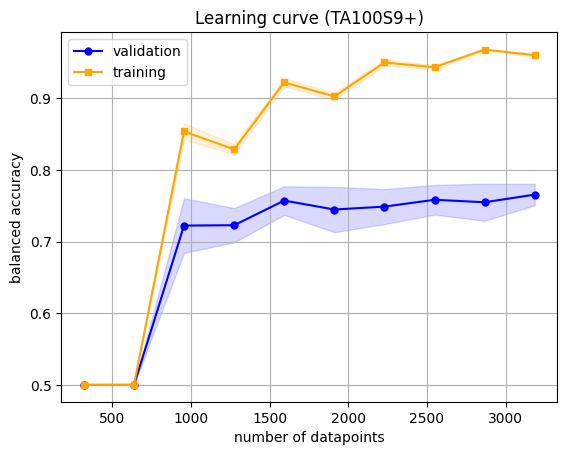

In [74]:
plt.plot(learning_curve.index, learning_curve['balanced_accuracy (validation)']['mean'], label='validation', color='blue', marker='o', markersize=5)
plt.fill_between(learning_curve.index, learning_curve['balanced_accuracy (validation)']['mean']-learning_curve['balanced_accuracy (validation)']['std'], learning_curve['balanced_accuracy (validation)']['mean']+learning_curve['balanced_accuracy (validation)']['std'], alpha=0.15, color='blue')
plt.plot(learning_curve.index, learning_curve['balanced_accuracy (training)']['mean'], label='training', color='orange', marker='s', markersize=5)
plt.fill_between(learning_curve.index, learning_curve['balanced_accuracy (training)']['mean']-learning_curve['balanced_accuracy (training)']['std'], learning_curve['balanced_accuracy (training)']['mean']+learning_curve['balanced_accuracy (training)']['std'], alpha=0.15, color='orange')
plt.grid()
plt.xlabel('number of datapoints')
plt.ylabel('balanced accuracy')
plt.title('Learning curve (TA100S9+)')
plt.legend()
plt.show()

Based on the above plot we can deduce that the model with this arbitrary choice of hyper parameters has probably not reached its capacity.

### How can we select the number of folds?

So far we set k=5 to illustrate how k-fold cross validation can be used for model evaluation. But why did we use 5 folds? Why not 2 or 10?

It is easy to build some first arguments. If the number of folds is small this means that we leave a large portion of the data for validation. This means that the obtained performance metrics may be pessimistically biased, assuming that the model has further capacity to improve. On the other hand, if k is too large then the variance of the evaluation metric will increase because we use fewer data points in the validation set. In addition, increasing the number of folds increases the computational cost for two reasons: we carry out more model trainings and each of these trainings takes longer because it uses more data (the validation only uses inference and is much faster than training). As it frequently happens with modelling we need to find the sweet spot. It has been demonstrated that there is no universal unbiased estimate of the variance of k-fold cross validation (https://www.jmlr.org/papers/v5/grandvalet04a.html).

There is a special case, namely k=n, where n is the size of the dataset. This can have practical applications when the dataset is small, but is otherwise very computationally demanding. In addition it has high variance because the n fitted models are highly correlated. More about this in the lectures.

In principle, the k-fold cross validation can be repeated with different random number seeds for splitting the dataset to the training and validation sets. This will give a more robust estimate of the performance metric but with some additional computational cost. Moreover, the validation sets will be overlapping that may have implications on the type of statistical tests for algorithm selection.

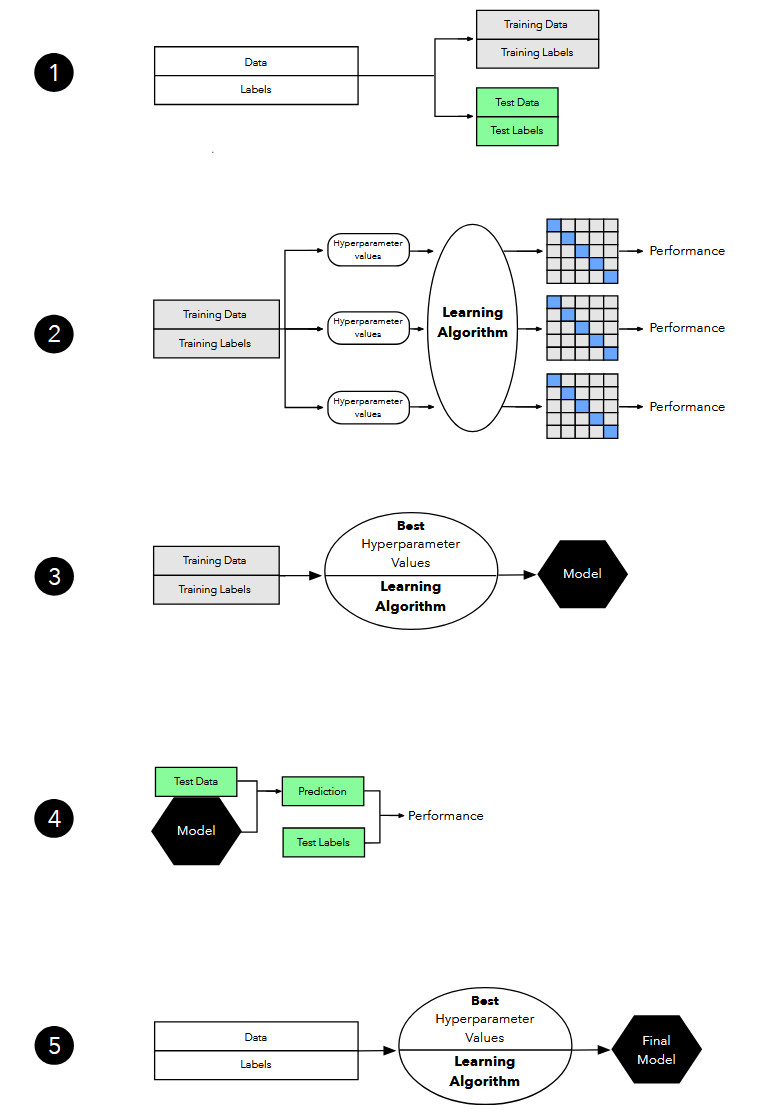

As a final note, when the dataset is very large using k-fold cross validation may be an overkill and a simple test/validation/training split may be sufficient. When the dataset is large high variance is not an issue, .i.e. it does not matter how we split the dataset.

In my opinion, the datasets usually derived from guideline studies, especially in vivo, are typically not large enough and cross-validation is likely the method of choice. However, high throughput methods may provide large datasets and hence a simple test/validation/training split may be sufficient.

Although this lab does not discuss feature selection and preprocessing (what is known as feature engineering) it is important to know that we should apply such steps within the folds. In other words, every training subset we generate drives the feature engineering to avoid leakage of information from the validation/test set into the training process.

## Validation curves

## Hyperparameter tuning

## k-Fold cross validation for model selection

Cross-validation for model selection resembles the more typical split of a dataset into test, validation and training subsets. The difference is that we introduce a loop over the folds.

The steps can be summarised as follows. We first set aside a test set that we will not touch during the model development process but keep it only for the final model evaluation.

The second step is the most interesting concept. We will need to try different sets of hyperparameters, such as the number of neural network layers and number of neurons in each layer. For each set of hyperparameters we would like to try we will repeat the k-fold cross validation by using only the training set.

We select the hyperameters that gave the best average validation performance across the folds.  With these hyperparameters we fit a model using the whole training set. This model is used for estimating the generalisation error using the test set. As an option we could also fit the final model to the whole dataset. We are not able to estimate its generalisation error because we ran out of data, but likley it is smaller than the generalisation error we computed in the previous step. This is the model that we use for inference, e.g. for prioritisation or hazard assessment.

The use of k-fold for cross validation is visually explained in the figure below(taken from https://doi.org/10.48550/arXiv.1811.12808).

## The law of parsimony

Occam's razor is a philosophical principle and something to keep in mind when building models (or carrying out any work in general!). If we have two models that perform equal well, i.e. they have comparable generalisation errors, we may give preference to the simple model, .e.g. the model wih the fewer weights in a neural network context.



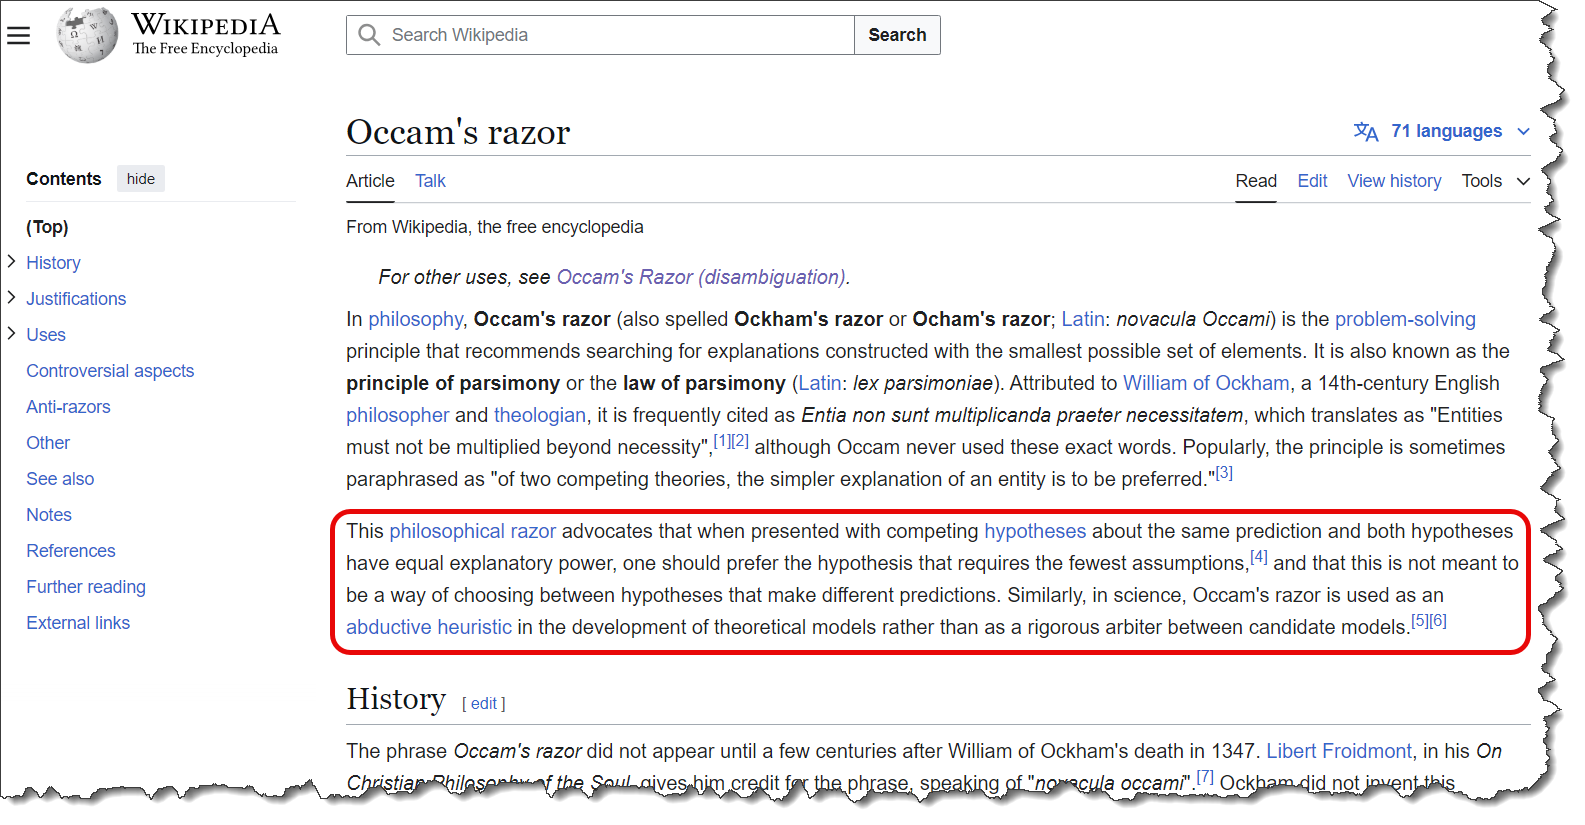

The definition was taken from Wikipedia (https://en.wikipedia.org/wiki/Occam%27s_razor).

The reason for which we may prefer a simpler model is computational efficiency and easier model interpretation. As an extreme simplification we may consider logistic regression to be the easier neural network with only one layer. The weights of this layer can be understood as the importance of the corresponding features. If we use a deep neural network with multiple layers (a multilayer perceptron) then the model intepretation is not so easy any more. In other words, if for a given problem logistic regression works as well as more advanced non-linear methods there is no reason to opt for the more complex models. This is something to keep in mind when reading deep learning literature as benefits of apparrently new algorithms may sometimes be exaggerated.

In this section we will contrast the predictive performance of some of the most promising models developed through-cross validation with the model complexity estimated through the number of weights and biases. Typically one may want to keep the simplest model within standard error of the optimal model. Not everyone agrees with this practice as some practitioners (that does not include the presenter) advocate that squeezing the last bit of predictive performance out of a model is something to strive for.